In [103]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import seaborn as sns

%matplotlib inline
pd.set_option('display.mpl_style', 'default')
pl.rcParams['figure.figsize'] = (20.0, 10.0)

train = pd.read_csv('train.csv', header=0, low_memory=False)
store_info = pd.read_csv('store.csv', header=0, low_memory=False)

train.Date = pd.to_datetime(train.Date)

store_info.CompetitionDistance = store_info.CompetitionDistance.fillna(0)
store_info.CompetitionOpenSinceMonth = store_info.CompetitionOpenSinceMonth.fillna(0).astype(int)
store_info.CompetitionOpenSinceYear = store_info.CompetitionOpenSinceYear.fillna(0).astype(int)
store_info.Promo2SinceWeek = store_info.Promo2SinceWeek.fillna(0).astype(int)
store_info.Promo2SinceYear = store_info.Promo2SinceYear.fillna(0).astype(int)

promo_intervals = [np.NaN] + list(store_info.PromoInterval.value_counts().index)
store_info.PromoInterval = store_info.PromoInterval.map(lambda x: promo_intervals.index(x))

In [104]:
train_grouped = train[train.Sales > 0].groupby('Store')

store_info['SalesMean'] = train_grouped.Sales.mean().reset_index().Sales
store_info['SalesMedian'] = train_grouped.Sales.median().reset_index().Sales
store_info['SalesStd'] = train_grouped.Sales.std().reset_index().Sales
store_info['SalesSum'] = train_grouped.Sales.sum().reset_index().Sales
store_info['SalesMax'] = train_grouped.Sales.max().reset_index().Sales
store_info['SalesMin'] = train_grouped.Sales.min().reset_index().Sales
store_info['SalesSkew'] = train_grouped.Sales.skew().reset_index().Sales

del train

In [105]:
store_info = pd.get_dummies(store_info, columns=['StoreType', 'Assortment'])

In [110]:
labels = store_info.Store.values
data = store_info.values[:, 1:]
data = normalize(data, norm='l1', axis=0)

In [107]:
def cluster_quality(groups, train_grouped):
    error = 0.
    for stores in groups.values():
        means = train_grouped.Sales.mean()[stores]
        error += means.map(lambda x: (x - means.mean())/x).sum()**2
    return np.sqrt(error)

min_k = 49 min_score = 18.5127116179


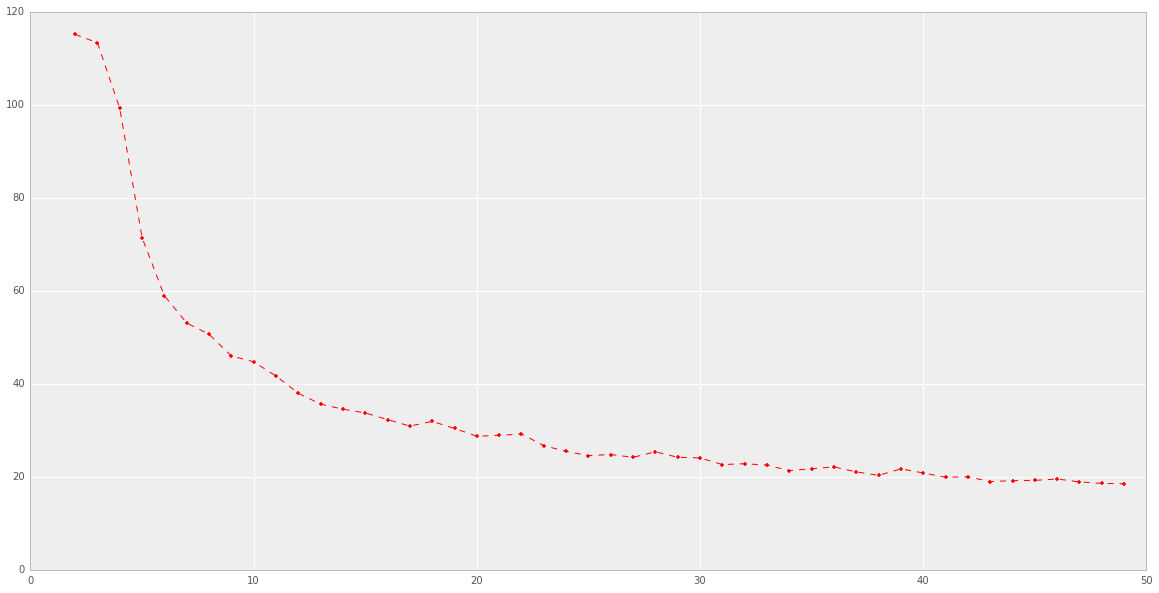

In [124]:
ks, scores = [], []
min_k, min_score = 2, 10**5
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, n_jobs=-1)
    clusters = kmeans.fit_predict(data)
    store_info['Cluster'] = clusters
    score = cluster_quality(store_info.groupby('Cluster').groups, train_grouped)
    scores.append(score)
    ks.append(k)
    if min_score >= score:
        min_score = score
        min_k = k
        
pl.plot(ks, scores, 'r.--')
print('min_k =', min_k, 'min_score =', min_score)

In [126]:
kmeans = KMeans(n_clusters=40, n_jobs=-1)
clusters = kmeans.fit_predict(data)
store_info['Cluster'] = clusters
print('quality =', cluster_quality(store_info.groupby('Cluster').groups, train_grouped))

quality = 20.2222898902


In [128]:
store_info.columns


Index(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'SalesMean', 'SalesMedian',
       'SalesStd', 'SalesSum', 'SalesMax', 'SalesMin', 'SalesSkew',
       'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c', 'Cluster'],
      dtype='object')

In [130]:
store_info[['Store', 'Cluster', 'SalesMean', 'SalesMedian', 'SalesStd', 'SalesSum', 'SalesMax',
            'SalesMin', 'SalesSkew']].to_csv('store_clusters.csv')
